# Single Semantic Adversarial Attacks in PyTorch

These are adversarial images that semantically represent the same objects as the original images. These types of attacks are discussed in the following papers:
1. [Semantic Adversarial Examples](https://arxiv.org/pdf/1804.00499.pdf) (CVPR Workshops 2018)
2. [Towards Compositional Adversarial Robustness: Generalizing Adversarial Training to Composite Semantic Perturbations](https://arxiv.org/pdf/2202.04235.pdf) (CVPR 2023) 

This tutorial demonstrates single semantic attacks examined in [2] on the CIFAR-10 dataset.
They are constructed by perturbing the following components of an image:
* Hue
* Saturation
* Rotation
* Brightness
* Contrast

---

Import the necessary modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from art.attacks.evasion.semantic_attacks import (
    BrightnessGradientPyTorch,
    ContrastGradientPyTorch,
    HueGradientPyTorch,
    SaturationGradientPyTorch
)
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10

Load the CIFAR-10 dataset

In [2]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()

# Swap the axes to PyTorch's NCHW format.
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

Create a simple ART classifier

In [3]:
# Create a simple convolutional neural network.
model = nn.Sequential(
    nn.Conv2d(3, 8, 5), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2, 2), 
    nn.Conv2d(8, 16, 5), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Flatten(), 
    nn.Linear(5*5*16, 128),    
    nn.Linear(128, 10)
)

# Define the loss function and the optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create the ART classifier.
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

Train and evaluate the classifier

In [4]:
# Train the ART classifier.
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=16, verbose=True)

# Evaluate the ART classifier on benign test examples.
predictions_benign = classifier.predict(x_test)

accuracy = np.sum(np.argmax(predictions_benign, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on the benign test set: {}%".format(accuracy * 100))

Accuracy on the benign test set: 54.769999999999996%


## Hue Attack


Generate the adversarial examples and evaluate the classifier on them

In [5]:
# Create the ART attacker.
attack = HueGradientPyTorch(
    classifier,
    norm=np.inf,
    factor_min=-np.pi,
    factor_max=np.pi,
    step_size=0.8,
    max_iter=10,
    num_random_init=1,
)

# Generate the adversarial examples.
x_test_adv = attack.generate(x_test)  # Untargeted.


# Evaluate the ART classifier on the adversarial examples.
predictions_adv = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on the adversarial test set: {}%".format(accuracy * 100))

Hue Attack:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on the adversarial test set: 35.85%


Visualize some successful adversarial examples

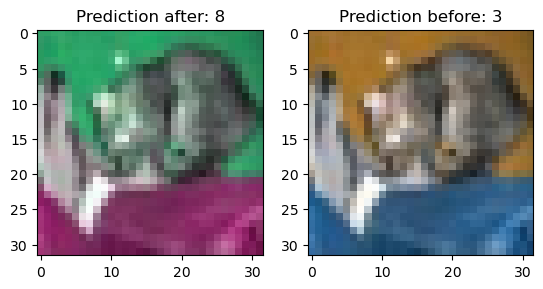

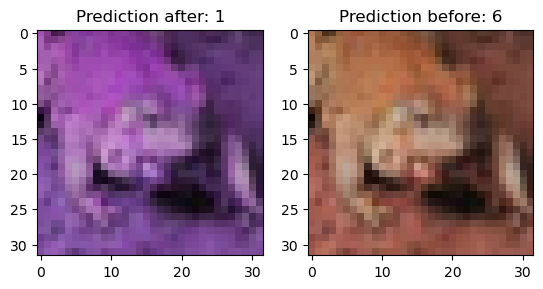

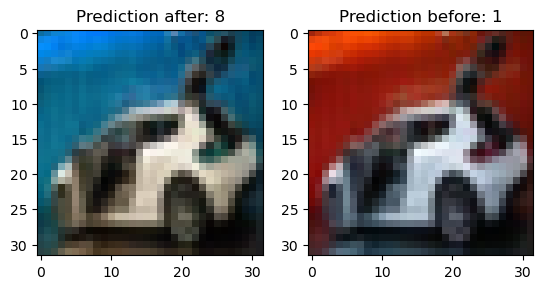

In [6]:
# Utility function for visualising some results.
def visualise(x_test, x_test_adv, predictions_benign, predictions_adv, y_test,
              num_viz=3):
      # Indices where (predictions_adv != predictions_benign) and (predictions_benign == y_test)
      indices = np.where(np.logical_and(
            np.equal(np.argmax(predictions_benign, axis=1), np.argmax(y_test, axis=1)),
            np.not_equal(np.argmax(predictions_benign, axis=1), np.argmax(predictions_adv, axis=1))))

      x_adv_viz = x_test_adv[indices].transpose(0, 2, 3, 1) * 255.0
      x_adv_viz = x_adv_viz.astype(np.uint8)
      x_viz = x_test[indices].transpose(0, 2, 3, 1) * 255.0
      x_viz = x_viz.astype(np.uint8)
      y_viz = y_test[indices]
      predictions_benign_viz = predictions_benign[indices]
      predictions_adv_viz = predictions_adv[indices]

      for i in range(num_viz):
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(x_adv_viz[i])
            ax[0].set_title("Prediction after: {}".format(np.argmax(predictions_adv_viz, axis=1)[i]))
            ax[1].imshow(x_viz[i])
            ax[1].set_title("Prediction before: {}".format(np.argmax(predictions_benign_viz, axis=1)[i]))
            plt.show()

visualise(x_test, x_test_adv, predictions_benign, predictions_adv, y_test)

## Saturation Attack


Generate the adversarial examples and evaluate the classifier on them

In [7]:
# Create the ART attacker.
attack = SaturationGradientPyTorch(
    classifier,
    norm=np.inf,
    factor_min=0.6,
    factor_max=1.4,
    step_size=0.08,
    max_iter=10,
    num_random_init=1,
)

# Generate the adversarial examples.
x_test_adv = attack.generate(x_test)  # Untargeted.


# Evaluate the ART classifier on the adversarial examples.
predictions_adv = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on the adversarial test set: {}%".format(accuracy * 100))

Saturation Attack:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on the adversarial test set: 53.65%


Visualize some successful adversarial examples

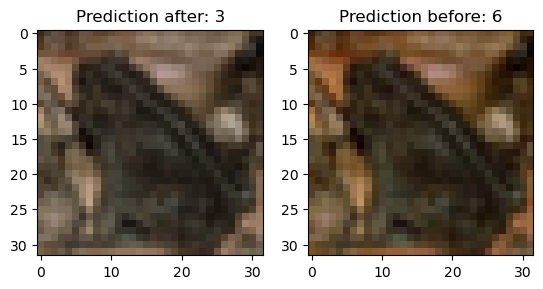

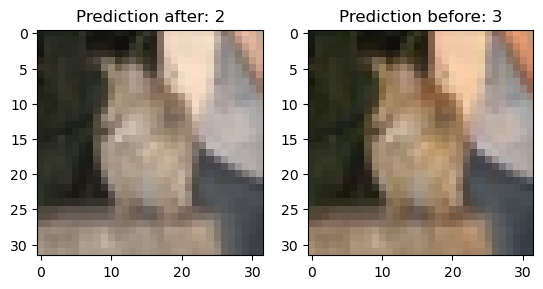

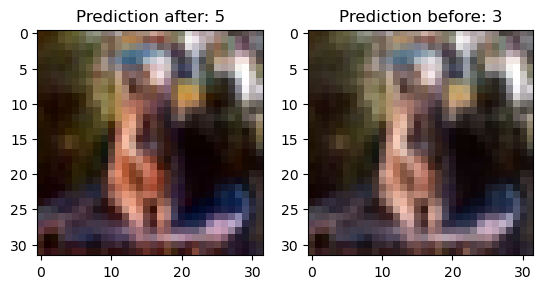

In [8]:
visualise(x_test, x_test_adv, predictions_benign, predictions_adv, y_test)

## Brightness Attacks

Generate the adversarial examples and evaluate the classifier on them

In [9]:
# Create the ART attacker.
attack = BrightnessGradientPyTorch(
    classifier,
    norm=np.inf,
    factor_min=-0.4,
    factor_max=0.4,
    step_size=0.08,
    max_iter=10,
    num_random_init=1,
)

# Generate the adversarial examples.
x_test_adv = attack.generate(x_test)  # Untargeted.


# Evaluate the ART classifier on the adversarial examples.
predictions_adv = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on the adversarial test set: {}%".format(accuracy * 100))

Brightness Attack:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on the adversarial test set: 31.86%


Visualize some successful adversarial examples

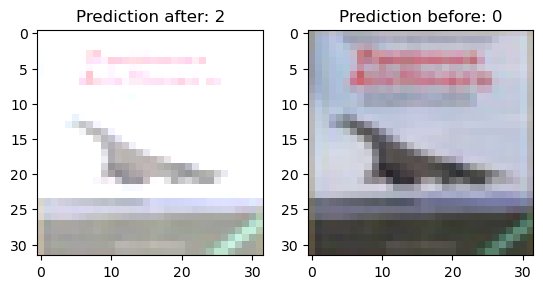

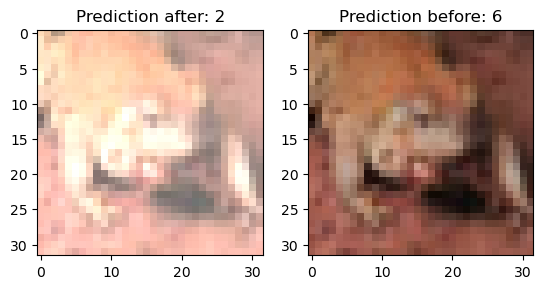

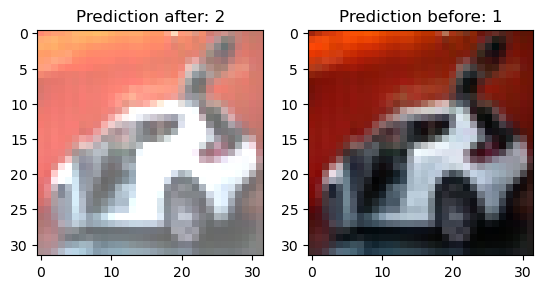

In [10]:
visualise(x_test, x_test_adv, predictions_benign, predictions_adv, y_test)

## Contrast Attack

Generate the adversarial examples and evaluate the classifier on them

In [11]:
# Create the ART attacker.
attack = ContrastGradientPyTorch(
    classifier,
    norm=np.inf,
    factor_min=0.7,
    factor_max=1.3,
    step_size=0.06,
    max_iter=10,
    num_random_init=1,
)

# Generate the adversarial examples.
x_test_adv = attack.generate(x_test)  # Untargeted.


# Evaluate the ART classifier on the adversarial examples.
predictions_adv = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on the adversarial test set: {}%".format(accuracy * 100))

Contrast Attack:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on the adversarial test set: 51.370000000000005%


Visualize some successful adversarial examples

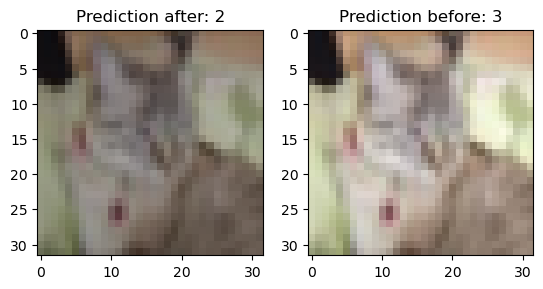

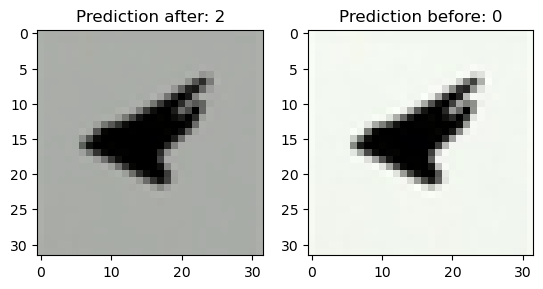

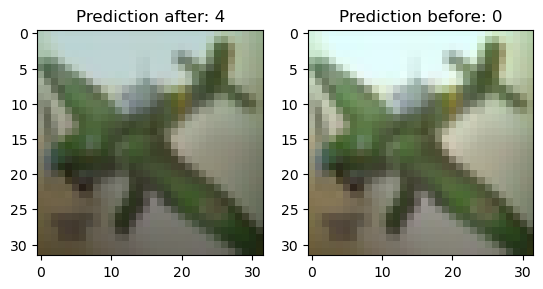

In [12]:
visualise(x_test, x_test_adv, predictions_benign, predictions_adv, y_test)